<a href="https://colab.research.google.com/github/Sulaimon99/MyFirstGit/blob/master/ML_capstone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
"""
INTRODUCTION
Income Level Prediction

This project focuses on building a machine learning model to predict whether an individual's income exceeds $50,000 per year using census data.

this work python notebook covers:
- Data cleaning and preparation
- Exploratory Data Analysis (EDA)
- Feature engineering
- Model development and evaluation
- Insights and recommendations


"\nINTRODUCTION\nIncome Level Prediction\n\nThis project focuses on building a machine learning model to predict whether an individual's income exceeds $50,000 per year using census data. \n\nOver the course of two weeks, the project covers:\n- Data cleaning and preparation\n- Exploratory Data Analysis (EDA)\n- Feature engineering\n- Model development and evaluation\n- Insights and recommendations\n\nThe final output is a well-structured Jupyter notebook showcasing the complete data science workflow.\n"

In [39]:
# === IMPORTS ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
!pip install python-pptx
from pptx import Presentation
from pptx.util import Inches


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)


In [24]:
# === EXPLORATORY DATA ANALYSIS ===
#Load Dataset
df = pd.read_csv("income_data.csv")
#clean columns and missing values
df.columns = df.columns.str.strip().str.lower().str.replace("-", "_")
df.replace(" ?", pd.NA, inplace=True)
df = df.dropna().copy()

In [25]:
# Create binary income column
df['income_binary'] = df['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)
df['income_label'] = df['income_binary'].map({0: '<=50K', 1: '>50K'})

# Create folder to save plots
plots_dir = "eda_plots"
os.makedirs(plots_dir, exist_ok=True)


In [26]:
# Define and save plots
def save_plot(plot_func, filename):
    plt.clf()
    plot_func()
    plt.savefig(os.path.join(plots_dir, filename), bbox_inches='tight')
    plt.close()

In [27]:
def plot_education_income():
    edu_income = pd.crosstab(df['education'], df['income_binary'], normalize='index') * 100
    edu_income.sort_values(1, ascending=False).plot(kind='bar', stacked=True, colormap='coolwarm')
    plt.title('Percentage of Individuals Earning >50K by Education Level')
    plt.ylabel('Percentage')
    plt.xlabel('Education Level')
    plt.legend(['<=50K', '>50K'], title='Income')
    plt.xticks(rotation=45)

In [28]:
def plot_gender_income():
    sns.barplot(data=df, x='sex', y='income_binary', hue='sex',
                estimator=lambda x: 100 * sum(x) / len(x), errorbar=None,
                palette='viridis', legend=False)
    plt.title('Percentage of Individuals Earning >50K by Gender')
    plt.ylabel('% Earning >50K')
    plt.xlabel('Gender')
    plt.ylim(0, 50)


In [29]:

def plot_hours_income():
    sns.histplot(data=df, x='hours_per_week', hue='income_binary', bins=30, kde=True,
                 element='step', stat='density')
    plt.title('Distribution of Weekly Working Hours by Income Group')
    plt.xlabel('Hours per Week')
    plt.ylabel('Density')

In [30]:
def plot_age_income():
    sns.histplot(data=df, x='age', hue='income_label', bins=30, kde=True,
                 stat='density', palette='Set2', element='step')
    plt.title('Age Distribution by Income Group')
    plt.xlabel('Age')
    plt.ylabel('Density')



In [31]:
def plot_occupation_income():
    top_occupations = df.groupby('occupation')['income_binary'].mean().sort_values(ascending=False) * 100
    top_occupations.plot(kind='bar', color='teal')
    plt.title('Percentage of >50K Earners by Occupation')
    plt.ylabel('% Earning >50K')
    plt.xlabel('Occupation')
    plt.xticks(rotation=45, ha='right')


In [32]:
# Save all plots
save_plot(plot_education_income, "education_vs_income.png")
save_plot(plot_gender_income, "gender_vs_income.png")
save_plot(plot_hours_income, "hours_vs_income.png")
save_plot(plot_age_income, "age_vs_income.png")
save_plot(plot_occupation_income, "occupation_vs_income.png")

In [33]:
# Create PowerPoint
prs = Presentation()
title_slide_layout = prs.slide_layouts[0]
slide = prs.slides.add_slide(title_slide_layout)
slide.shapes.title.text = "Exploratory Data Analysis: Income Dataset"
slide.placeholders[1].text = "Generated with Python & Matplotlib"

# Add insight slides
insights = [
    ("Education vs Income", "Higher education correlates with higher income.",
     "education_vs_income.png"),
    ("Gender Income Disparity", "Males are significantly more likely to earn >50K than females.",
     "gender_vs_income.png"),
    ("Working Hours vs Income", "High earners tend to work longer hours.",
     "hours_vs_income.png"),
    ("Age vs Income", "Mid-age individuals (30–60) dominate the high income group.",
     "age_vs_income.png"),
    ("Occupation vs Income", "Exec-managerial and Prof-specialty roles lead in income.",
     "occupation_vs_income.png")
]

for title, desc, img in insights:
    layout = prs.slide_layouts[5]
    slide = prs.slides.add_slide(layout)
    slide.shapes.title.text = title
    left = Inches(0.5)
    top = Inches(1.5)
    height = Inches(4.5)
    slide.shapes.add_picture(os.path.join(plots_dir, img), left, top, height=height)
    txBox = slide.shapes.add_textbox(Inches(0.5), Inches(0.2), Inches(9), Inches(1))
    tf = txBox.text_frame
    tf.text = desc

# Save PowerPoint
prs.save("Income_Data_EDA_Summary.pptx")

In [34]:
# === MODELING AND EVALUATION SECTION ===

# Drop unnecessary columns (corrected)
df.drop(['fnlwgt', 'education_num'], axis=1, inplace=True)

In [35]:
# Impute missing values (corrected column names)
cols_to_fill = ['workclass', 'occupation', 'native_country']
impute = SimpleImputer(strategy='most_frequent')
df[cols_to_fill] = impute.fit_transform(df[cols_to_fill])

In [37]:

# Prepare features and labels
y = df['income']
x = df.drop('income', axis=1)

x_num = x.select_dtypes(include=np.number)
x_cat = x.select_dtypes(exclude=np.number)


In [ ]:
# Encode categorical features
cat_encoder = OneHotEncoder(sparse_output=False)
encoded_cat = cat_encoder.fit_transform(x_cat)

In [ ]:
# Encode labels
y_encoder = LabelEncoder()
encoded_y = y_encoder.fit_transform(y)

In [ ]:
# Scale numerical features
num_scaler = MinMaxScaler()
scaled_num = num_scaler.fit_transform(x_num)

In [ ]:
# Combine processed features
df_num = pd.DataFrame(scaled_num, columns=x_num.columns)
df_cat = pd.DataFrame(encoded_cat, columns=cat_encoder.get_feature_names_out())
df_preprocessed = pd.concat([df_num, df_cat], axis=1)

In [ ]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(df_preprocessed, encoded_y, test_size=0.1, random_state=20)


In [ ]:
# === MODEL TRAINING ===

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(x_train, y_train)
y_pred_log = log_reg.predict(x_test)


In [ ]:
# KNN
knn_classif = KNeighborsClassifier(n_neighbors=5)
knn_classif.fit(x_train, y_train)
y_pred_knn = knn_classif.predict(x_test)

# SVM
svm_linear = SVC(kernel='linear')
svm_linear.fit(x_train, y_train)
y_pred_svm = svm_linear.predict(x_test)

# Decision Tree
tree = DecisionTreeClassifier(max_depth=100)
tree.fit(x_train, y_train)
y_pred_tree = tree.predict(x_test)

Income value counts:
income
<=50K    36080
>50K     11541
Name: count, dtype: int64

Decision Tree Confusion Matrix:


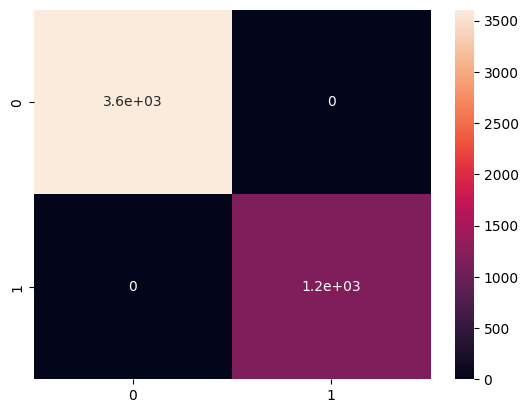


Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3607
           1       1.00      1.00      1.00      1156

    accuracy                           1.00      4763
   macro avg       1.00      1.00      1.00      4763
weighted avg       1.00      1.00      1.00      4763


ROC AUC Score (Decision Tree): 1.0


In [38]:
# === EVALUATION ===
print("Income value counts:")
print(df['income'].value_counts())

print("\nDecision Tree Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred_tree), annot=True)
plt.show()

print("\nClassification Report (Decision Tree):")
print(classification_report(y_test, y_pred_tree))

print("\nROC AUC Score (Decision Tree):", roc_auc_score(y_test, y_pred_tree))